In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = np.loadtxt('cluster.dat').T

In [50]:
import sys
import functools


class Annealer:
    
    def __init__(self, initial=0.5, annealing=0.9):
        self._initial = initial
        self._annealing = annealing
    
    def __call__(self, iterations):
        learning_rate = self._initial
        for _ in range(iterations // 4):
            yield learning_rate
        while True:
            learning_rate *= self._annealing
            yield learning_rate


class OnlineKMeans:
    
    def __init__(self, k, seed=0):
        self._k = k
        self._random = np.random.RandomState(seed)

    def __call__(self, data, iterations, annealer):
        centers = self._init_centers(data)
        learning_rates = annealer(iterations)
        for time_step in range(iterations):
            point = data[self._random.choice(len(data))]
            assignment, distance = self._assignment(centers, point)
            offset = point - centers[assignment]
            centers[assignment] += next(learning_rates) * offset
            yield centers.copy()
    
    def _init_centers(self, data, distance=0.5):
        mean, cov = data.mean(axis=0), distance * np.cov(data.T).T
        centers = self._random.multivariate_normal(mean, cov, (self._k))
        return centers

    @classmethod
    def _assignment(cls, centers, point):
        distances = cls._distance(centers, point)
        assignment = np.argmin(distances)
        distance = distances[assignment]
        return assignment, distance

    @staticmethod
    def _distance(centers, point):
        offset = centers - point.reshape(1, -1)
        return (np.abs(offset)).sum(axis=1)
    

def error(centers, points):
    points = points.T
    error = 0
    for p in points:
        error += np.sum((p[:2] - centers[int(p[2])]) ** 2)
    error = error / (2 * points.shape[0])
    return error


def plot_clusters(centers, data, iterations):
    title = 'Clusters after {} iterations'.format(iterations)
    print(title)
    assignments = [OnlineKMeans._assignment(centers, x)[0] for x in data]
    fig, ax = plt.subplots()
    # fig.suptitle(title, fontsize=12)
    colors = np.arange(len(centers))
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], c=colors[assignments])
    ax.scatter(centers[:, 0], centers[:, 1], c=colors, s=200)
    fig.tight_layout()
    return ax

Clusters after 0 iterations


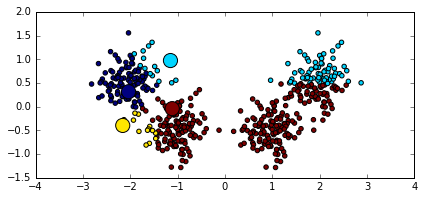

Clusters after 125 iterations


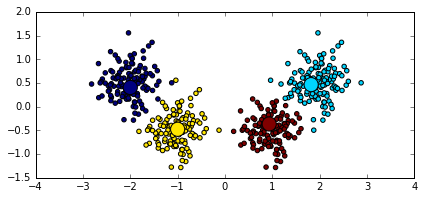

Clusters after 250 iterations


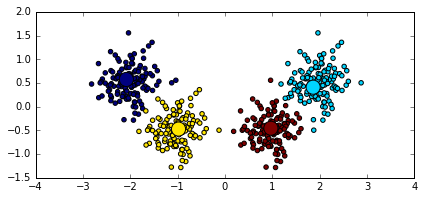

Clusters after 375 iterations


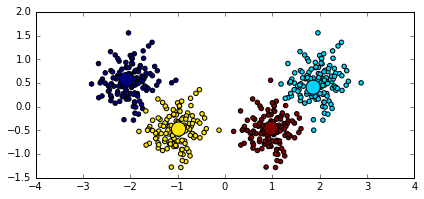

Clusters after 500 iterations


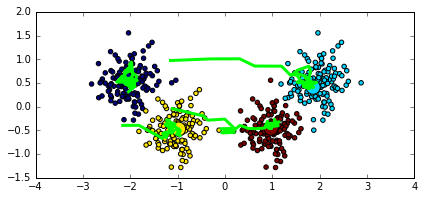

Error over number of iterations


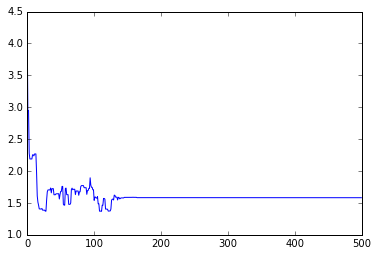

In [51]:
iterations = len(data)
annealer = Annealer(0.3, 0.9)
clustering = OnlineKMeans(4)(data, iterations, annealer)
all_centers = np.empty((iterations, 4, 2))
for index, centers in enumerate(clustering):
    if index % (iterations // 4) == 0:
        plot_clusters(centers, data, index)
        plt.show()
    all_centers[index] = centers
all_centers = np.array(all_centers)
    
ax = plot_clusters(centers, data, iterations)
for center in range(all_centers.shape[1]):
    ax.plot(all_centers[:, center, 0], all_centers[:, center, 1], c='lime', lw=3)
plt.show()

print('Error over number of iterations')
errors = np.array([error(centers, data) for centers in all_centers])
fig, ax = plt.subplots()
ax.plot(np.arange(iterations), errors)
plt.show()